In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from functions_sandbox import cleaner

location = r"D:\IT_projects\Turing_Colledge\Modul2\Sprint2\project\cookie_cats\cookie_cats.csv"
cookie_cats = pd.read_csv(location)

In [2]:
cookie_cats.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
cookie_cats.tail(5)

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [4]:
cookie_cats = cleaner(cookie_cats, info=True)

All columns empty spaces have been stripped.
All columns names have been converted to lowercase.

Is there any duplicates?: False
Is there any NaN numbers?: False
Is there any empty cells?: False
Dataframe shape: (90189, 5)


In [5]:
cookie_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
#True/False to 1/0
cookie_cats[["retention_1", "retention_7"]] = cookie_cats[["retention_1", "retention_7"]].astype(int)

## Exploratory Data Analysis

In [16]:
cookie_cats[["userid", "sum_gamerounds"]].describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


In [44]:
proportions = (
    cookie_cats.groupby("version")
    .agg(
        {
            "userid": "count",
            "retention_1": lambda x: (x == 1).sum(),
            "retention_7": lambda x: (x == 1).sum(),
        }
    )
    .reset_index()
)
proportions["ret1_prop"] = (proportions["retention_1"] / proportions["userid"]) * 100
proportions["ret7_prop"] = (proportions["retention_7"] / proportions["userid"]) * 100
proportions

,version,userid,retention_1,retention_7,ret1_prop,ret7_prop
0,gate_30,44700,20034,8502,44.818792,19.020134
1,gate_40,45489,20119,8279,44.228275,18.200004


Fairly similar user counts.

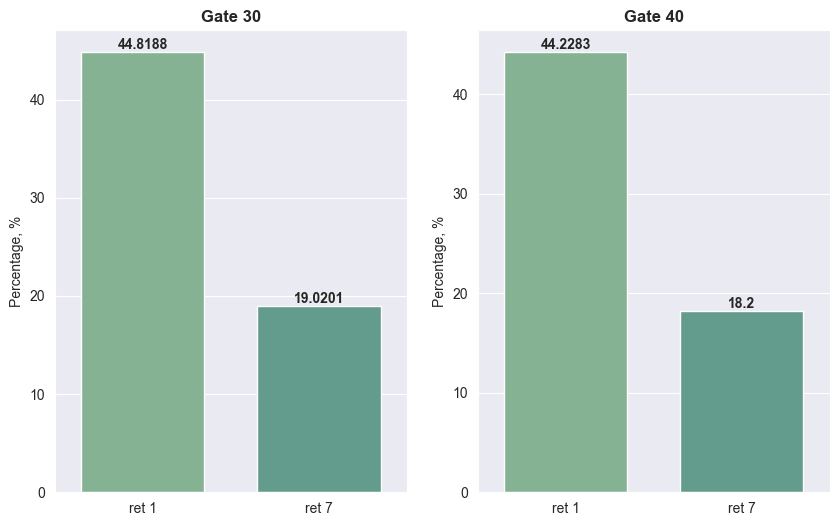

In [62]:
g30x = ["ret 1", "ret 7"]
g30y = [proportions.loc[0, "ret1_prop"], proportions.loc[0, "ret7_prop"]]
g40x = ["ret 1", "ret 7"]
g40y = [proportions.loc[1, "ret1_prop"], proportions.loc[1, "ret7_prop"]]

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.set_palette("crest")

sns.barplot(x=g30x, y=g30y, hue=g30x, width=0.7, ax=ax[0])
ax[0].set_ylabel("Percentage, %")
ax[0].set_title("Gate 30", fontweight="bold", ha="center")
for container in ax[0].containers:
    ax[0].bar_label(container, fontweight="bold")

sns.barplot(x=g40x, y=g40y, hue=g40x, width=0.7, ax=ax[1])
ax[1].set_ylabel("Percentage, %")
ax[1].set_title("Gate 40", fontweight="bold", ha="center")
for container in ax[1].containers:
    ax[1].bar_label(container, fontweight="bold")

plt.show()

#### Bootstrap statistics

In [60]:
def bootstrap(df, contr_test_param, metric, iters=500):
    bootstr = []
    for i in range(iters):
        bootmean = df.sample(frac=1, replace=True).groupby(contr_test_param)[metric].mean()
        bootstr.append(bootmean)
    bootstr = pd.DataFrame(bootstr)
    return bootstr

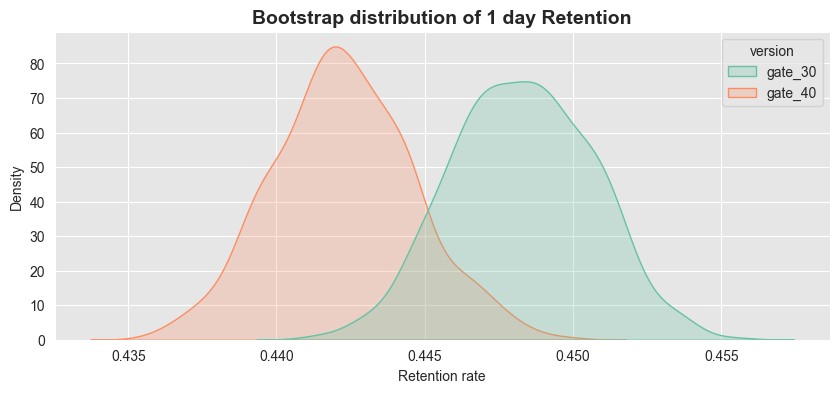

In [73]:
ret_1_boot = bootstrap(df=cookie_cats, contr_test_param="version", metric="retention_1")
plt.figure(figsize=(10, 4))
sns.set_style("darkgrid", {"axes.facecolor":".9"})
sns.kdeplot(data=ret_1_boot, fill=True, palette="Set2")
plt.xlabel("Retention rate")
plt.title(
    "Bootstrap distribution of 1 day Retention",
    fontsize=14,
    fontweight="bold",
    ha="center"
)

plt.show()

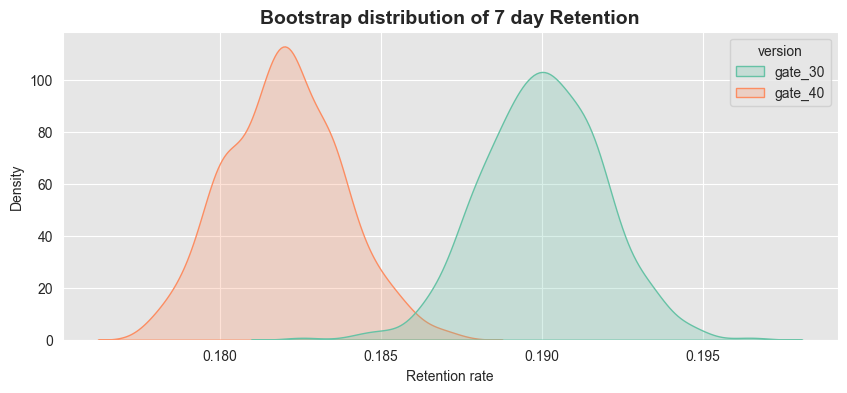

In [71]:
ret_7_boot = bootstrap(df=cookie_cats, contr_test_param="version", metric="retention_7")
plt.figure(figsize=(10, 4))
sns.set_style("darkgrid", {"axes.facecolor":".9"})
sns.kdeplot(data=ret_7_boot, fill=True, palette="Set2")
plt.xlabel("Retention rate")
plt.title(
    "Bootstrap distribution of 7 day Retention",
    fontsize=14,
    fontweight="bold",
    ha="center"
)

plt.show()

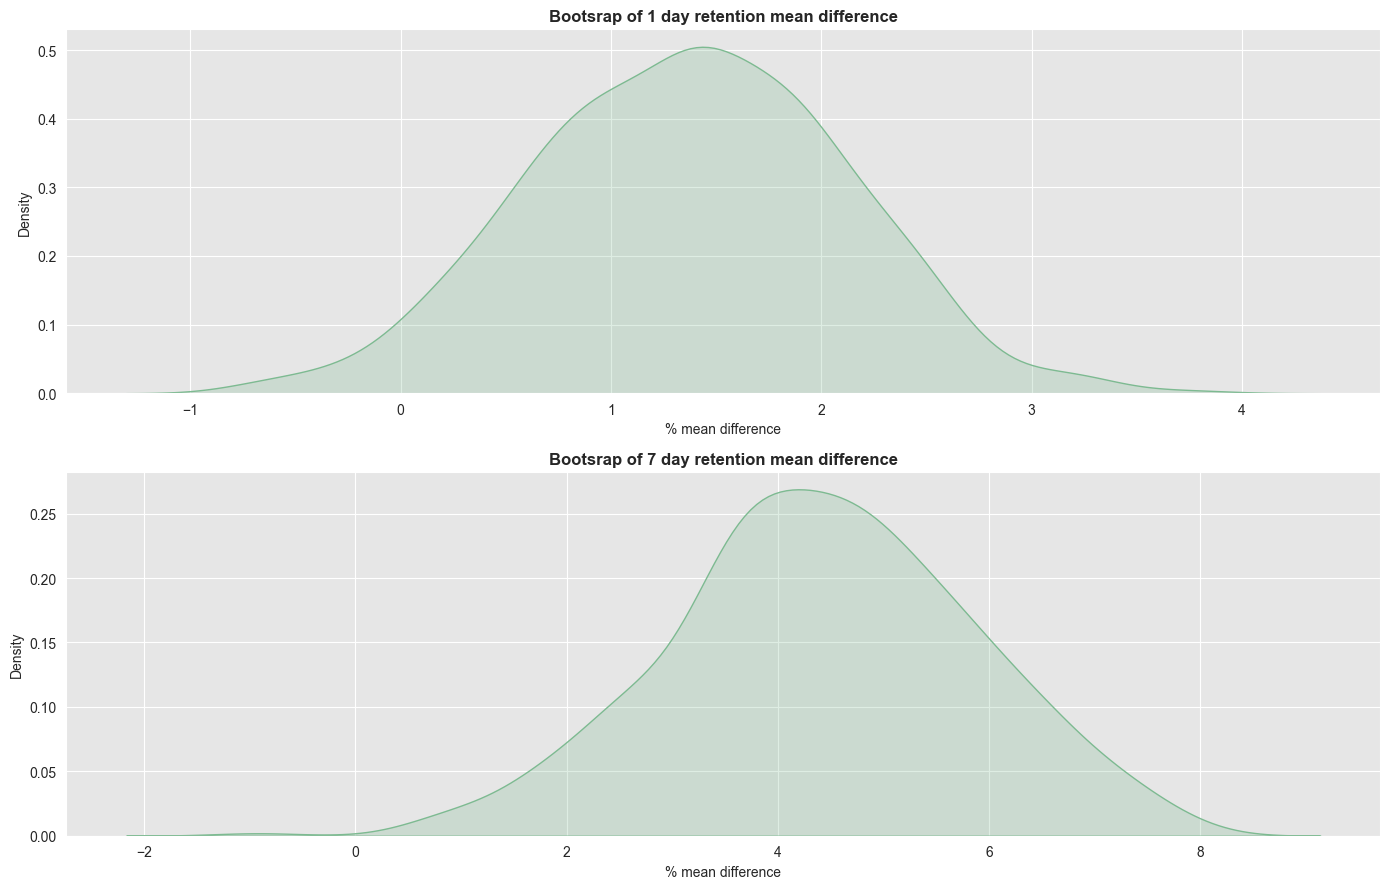

In [79]:
ret_1_boot["diff"] = (ret_1_boot["gate_30"] - ret_1_boot["gate_40"]) / ret_1_boot["gate_40"] * 100
ret_7_boot["diff"] = (ret_7_boot["gate_30"] - ret_7_boot["gate_40"]) / ret_7_boot["gate_40"] * 100

fig, ax = plt.subplots(2, 1, figsize=(14, 9))
sns.set_style("darkgrid", {"axes.facecolor":".9"})
sns.kdeplot(data=ret_1_boot["diff"], fill=True, ax=ax[0])
ax[0].set_xlabel("% mean difference")
ax[0].set_title("Bootsrap of 1 day retention mean difference", fontweight="bold")

sns.kdeplot(data=ret_7_boot["diff"], fill=True, ax=ax[1])
ax[1].set_xlabel("% mean difference")
ax[1].set_title("Bootsrap of 7 day retention mean difference", fontweight="bold")
plt.tight_layout()

plt.show()